## Climate Analysis and Exploration

In [1]:
# import dependencies
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func,distinct
import datetime as dt
import numpy as np

In [2]:
# connect to hawaii.sqlite 
engine = create_engine("sqlite:///output/hawaii.sqlite", echo=False)

# use automap base
# reflect Database into ORM classes 
Base = automap_base()
Base.prepare(engine, reflect=True)
# check if classes are relected
Base.classes.keys()

['measurement', 'station']

In [3]:
# Map measurement to an object 
ME = Base.classes.measurement
# Map station to an object 
ST = Base.classes.station

In [4]:
# create a session
session=Session(engine)

In [5]:
columns = inspect(engine).get_columns('measurement')

In [6]:
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
columns_st = inspect(engine).get_columns('station')
for c in columns_st:
    print(c['name'], c['type'])

id INTEGER
name TEXT
station TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Precipitation Analysis

,Precipitation
count,650.000000
mean,0.166246
std,0.429498
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.250000


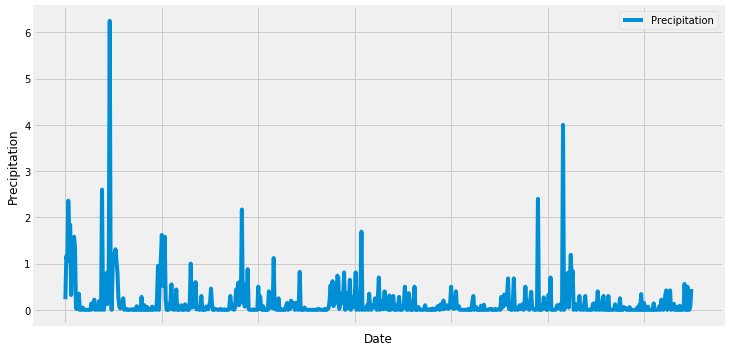

In [8]:
# set up today and a year ago's date
today = dt.date.today()
year_ago = today.replace(year = today.year-1)

#get the precipitation of each day between last year today and today and order by date
prcp_last_year = session.query(ME.date,ME.prcp).filter((ME.date>year_ago)&(ME.date<today)).order_by(ME.date).all()
        
#get the query results into df
df_prcp = pd.DataFrame(prcp_last_year,columns=['Date','Precipitation']).set_index('Date')

#plot a bar graph and save as png
df_prcp.plot(figsize=(10,5))
plt.tight_layout()
plt.ylabel('Precipitation')
plt.savefig('output/precipitation.png',bbox_inches = 'tight')

#describe a summary of analysis
df_prcp.describe()

## Station Analysis

In [9]:
# find the number of stations
number_stations = session.query(func.count(distinct(ME.station))).one()
print(number_stations[0])

9


In [10]:
# Design a query to find the most active station
most_active_station = session.query(ME.station,func.count(ME.prcp)).group_by(ME.station).order_by(func.count(ME.prcp).desc()).limit(1).all()
most_active_station

[('USC00519281', 2772)]

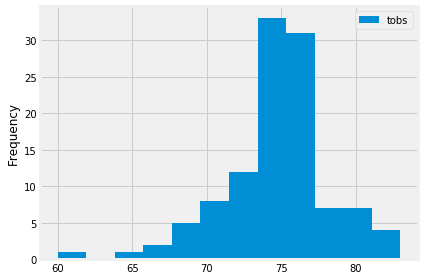

In [11]:
#Design a query to retrieve the last 12 monts of temperature observation data(tobs)
#query for all the tobs data in the past 12 months observed by the most active station
tobs_active_station_last_year = session.query(ME.tobs).filter((ME.date>year_ago)&(ME.date<=today)).filter(ME.station==most_active_station[0][0]).all()
#make tobs into a df and plot
tobs_df = pd.DataFrame(tobs_active_station_last_year,columns=['tobs'])
tobs_df.plot.hist(bins=12)
plt.tight_layout()
plt.savefig('output/tobs_hist.png')

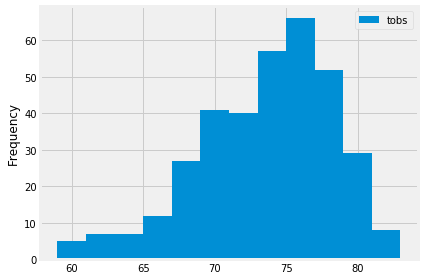

In [12]:
#Design a query to retrieve the last 12 monts (here last 12 months from the record) 
#of temperature observation data(tobs)

#query for the last date recorded
last_date_query = session.query(ME.date).order_by(ME.date.desc()).limit(1).all()[0][0]

#change it into a date object 
last_date_recorded = dt.datetime.strptime(last_date_query, '%Y-%m-%d').date() 

#get last year recorded
recorded_last_year = last_date_recorded.replace(year=last_date_recorded.year-1)

#query for all the tobs data in the past 12 months observed by the most active station
tobs_active_station_last_year_recorded=session.query(ME.tobs).\
                                        filter((ME.date>recorded_last_year)&(ME.date<=last_date_recorded)).\
                                        filter(ME.station==most_active_station[0][0]).all()
#make tobs into a df and plot
tobs_df_recorded = pd.DataFrame(tobs_active_station_last_year_recorded,columns=['tobs'])
tobs_df_recorded.plot.hist(bins=12)
plt.tight_layout()
plt.savefig('output/tobs_hist_last_year_recorded.png')

## Temperature Analysis

In [13]:
#define a function to take a start and end date in the format of %Y-%m-%d and find the matching 
#results from the previous year and query for tobs 

def calc_temps(start,end):
    #convert text input into datetime object
    start_date = dt.datetime.strptime(start, '%Y-%m-%d').date()
    end_date = dt.datetime.strptime(end, '%Y-%m-%d').date()
    #find the date of previouse year
    start_search = start_date.replace(year=start_date.year-1)
    end_search = end_date.replace(year=end_date.year-1)
    #make queries
    ave_tobs = session.query(func.avg(ME.tobs)).filter((ME.date>=start_search)&(ME.date<=end_search)).all()[0][0]
    print(f'debug average tobs between {start_search} and {end_search} is {ave_tobs}')
    min_tobs = session.query(func.min(ME.tobs)).filter((ME.date>=start_search)&(ME.date<=end_search)).all()[0][0]
    print(f'debug min of tobs is between {start_search} and {end_search} is {min_tobs}')
    max_tobs = session.query(func.max(ME.tobs)).filter((ME.date>=start_search)&(ME.date<=end_search)).all()[0][0]
    print(f'debug min of tobs is between {start_search} and {end_search} is {max_tobs}')
    return ave_tobs,min_tobs,max_tobs

debug average tobs between 2017-04-11 and 2017-05-11 is 73.74137931034483
debug min of tobs is between 2017-04-11 and 2017-05-11 is 58.0
debug min of tobs is between 2017-04-11 and 2017-05-11 is 83.0


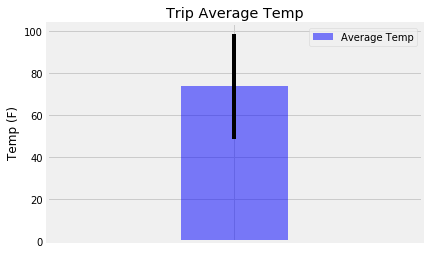

In [14]:
#I am gonna take a hypothetical one month vacation starting from my birthday this year
ave_tobs,min_tobs,max_tobs=calc_temps('2018-04-11','2018-05-11')

#make a df for plotting using ave_tobs
df_plot = pd.DataFrame([(ave_tobs)],columns=['Average Temp'])

#now plot
df_plot.plot.bar(yerr=(max_tobs-min_tobs),width=0.2,color='b',alpha=0.5)
plt.tick_params(
    axis ='x',          # changes apply to the x-axis
    which ='both',      # both major and minor ticks are affected
    bottom ='off',      # ticks along the bottom edge are off
    top ='off',         # ticks along the top edge are off
    labelbottom ='off')

# plt.tight_layout()
plt.ylabel('Temp (F)')
plt.title('Trip Average Temp')
plt.savefig('output/trip_ave_temp.png',bbox_inches = 'tight')